# Homework 4
#### Assigned: 2019-04-04
#### Due EOD: 2019-04-14

Based on Lecture 9
+ The student fills in the <...> fields.  
+ The student can create as many new cells as necessary in the solution sections.

*Useful LaTeX macros that save typing (click into cell to see them)*
$\def\expect{\mathbb{E}}$
$\def\cov{\mathrm{Cov}}$
$\def\var{\mathrm{Var}}$

#### Name:  Mengheng Xue
#### NetID: mx586

## Problem 1 (30 points)

We have an AR(1) model of the form
$$ 
x_t = \phi_0 + \phi_1 x_{t-1} + \epsilon_t  \qquad (1)
$$ 
At all times $t$ and $s$, the white noise $\epsilon_t$ has the properties
$$
\expect (\epsilon_t) = 0,  \qquad \cov(\epsilon_t, \epsilon_s) = \sigma^2 \delta_{t,s}  \qquad (2)
$$

Show the following:  

1. Mean $$\expect(x_t) = \frac{\phi_0}{1-\phi_1}$$

2. Autocovariance $$\gamma(h) := \cov(x_{t+h}, x_t) = \sigma^2\frac{\phi_1^h}{1-\phi_1^2}$$

3. ACF $$\rho(h) = \phi_1^h$$

## Solution 1

1. Mean:
\begin{align*}
\expect(x_t) &= \expect(\phi_0 +\phi_1 x_{t-1} + \epsilon_t) \\
& = \phi_0 + \phi_1\expect(x_{t-1}) + \expect(\epsilon_t)\\
& = \phi_0 + \phi_1\expect(x_{t}) & (\text{since $X_t$ is wide-sense stationary, } \expect(x_t)= \expect(x_{t-1}) \text{ and } \epsilon_t \text{ is white noise, }\expect(\epsilon_t) = 0 ) \\
\end{align*}
Therefore,  $\expect(x_t) = \frac{\phi_0}{1-\phi_1}$.

2. Variance:
\begin{align*}
\var(x_t) & = \var(\phi_0 +\phi_1 x_{t-1} + \epsilon_t) \\
& = \phi_1^2 \var(x_t) + \sigma^2 & (\text{since $X_t$ is WSS, } \var(x_t)= \var(x_{t-1}) \text{ and } \epsilon_t \text{ is white noise, }\var(\epsilon_t) = \sigma^2 )\\
\end{align*}
Therefore, $\var(x_t) = \frac{\sigma^2}{1-\phi_1^2}$. Let us define $\expect(x_t) = \mu$. Then, we could obtain autocovariance that
\begin{align*}
\gamma(h) = \cov(x_{t+h}, x_t) & = \expect \left[(x_{t+h}-\mu)(x_t-\mu)\right]\\
& = \expect \left[(\phi_0 + \phi_1x_{t+h-1}+\epsilon_{t+h}-\mu)(x_t-\mu)\right]\\
& = \phi_0 \expect (x_t-\mu) + \phi_1\expect[x_{t+h-1}(x_t-\mu)] + \expect \left[\epsilon_{t+h}(x_t-\mu)\right] - \mu\expect (x_t-\mu) & (\text{since } \expect (x_t-\mu)=0 \text{ and } \epsilon_{t+h} \text{ indept with } x_t, \expect(\epsilon_{t+h})=0)\\
& = \phi_1\expect[x_{t+h-1}(x_t-\mu)]\\
& = \phi_1 \gamma(h-1)
\end{align*}
By recursion, we could obtain that $\gamma(h) = \phi_1^h\gamma(0)$. We know that $\gamma(0)=\var(x_t)$, so we can obtain that
\begin{equation*}
\gamma(h) = \sigma^2\frac{\phi_1^h}{1-\phi_1^2}\;.
\end{equation*}

3. ACF:
\begin{align*}
\rho(h) &= \frac{\gamma(h)}{\var(x_t)}\\
& = \phi_1^h\;.
\end{align*}



## Problem 2 (70 points)

Univariate times series modeling of the S&P 500 over the period 2004-2006.

The data file "stock-treasury-2004_2006.csv", to be found in the "Data" folder, contains the following:  
+ TREAS_3M: the yield of the 3-month treasury note in percent (i.e 2.1 means 2.1%)
+ Adjusted close price of ten major stocks: GM, F, UTX, CAT, MRK, PFE, IBM, MSFT, C, XOM
+ SP: The S&P 500 equity index level at the close of the trading day  

**Do the following:**  

Use the pandas read_csv function to read only the Date and SP columns in a data frame called "sp_df".  
Rename the "SP" column into "ClosePx" in the same read_csv call.  
Compute the close-to-close index returns as:  $r_t = P_{t+1}/P_t - 1$ and add them as a new column "DailyRet".  
It is recommended to express all daily returns in basis points (10,000 bps = 100% = 1)

Fit ARIMA models on the DailyRet time series, up to AR order p=2, MA order q=2, and differencing order d=1.  
You can reuse the utility function auto_arima or provide your own.  
Display the summary of the best selected model based on the AIC criterion.  
Plot the original returns series and the predictions of the best selected model using the model's plot_predict method.

Run the Jarque-Bera normality test on the residuals of the best selected ARIMA model, and produce the qq plot of the residuals.  
Repeat the Jarque-Bera test and the qq plot using the residuals of the white noise model ARMA(0, 0).  
Compare the two and comment on whether they are really different.  


## Solution 2

### Packages

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from mlutils import run_adf_test, auto_arima

### Data

In [3]:
datapath = 'stock-treasury-2004_2006.csv'
cols = ['Date', 'SP']
sp_df = pd.read_csv(datapath, usecols=cols)
sp_df = sp_df.rename(columns={'SP': 'ClosePx'}) # Rename the "SP" column into "ClosePx" 
sp_df.head(5)


,Date,ClosePx
0,02-Jan-04,1108.48
1,05-Jan-04,1122.22
2,06-Jan-04,1123.67
3,07-Jan-04,1126.33
4,08-Jan-04,1131.92


### Computation of Returns

In [4]:
# compute returns and safe assign them
sp_df = sp_df.assign(DailyRet=10000*(sp_df.ClosePx.shift(-1, axis = 0) / sp_df.ClosePx -1))
sp_df = sp_df.iloc[:-1] # remove the last row so that there are no NaN returns
sp_df.head()

,Date,ClosePx,DailyRet
0,02-Jan-04,1108.48,123.953522
1,05-Jan-04,1122.22,12.920818
2,06-Jan-04,1123.67,23.672431
3,07-Jan-04,1126.33,49.630215
4,08-Jan-04,1131.92,-88.875539


### ARIMA Model Fitting
+ Using our utility function to find the best ARIMA model.

In [5]:
best_arima, results = auto_arima(sp_df.DailyRet.values, p_max = 2, q_max = 2, d_max=1, verbose=True)

ARIMA(0, 0, 0) AIC:7578.85  BIC:7587.87
ARIMA(0, 0, 1) AIC:7579.90  BIC:7593.43
ARIMA(0, 0, 2) AIC:7578.43  BIC:7596.47
ARIMA(0, 1, 0) AIC:8054.73  BIC:8063.75
ARIMA(0, 1, 1) AIC:7577.06  BIC:7590.58
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
ARIMA(1, 0, 0) AIC:7580.03  BIC:7593.56
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
ARIMA(1, 1, 0) AIC:7879.46  BIC:7892.99
ARIMA(1, 1, 1) AIC:7578.31  BIC:7596.34


C:\Users\mengh\Anaconda3\envs\python35\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\mengh\Anaconda3\envs\python35\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2) AIC:7575.34  BIC:7597.88
ARIMA(2, 0, 0) AIC:7578.58  BIC:7596.62
ARIMA(2, 0, 1) AIC:7579.44  BIC:7601.99


C:\Users\mengh\Anaconda3\envs\python35\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(2, 0, 2) AIC:7574.90  BIC:7601.96
ARIMA(2, 1, 0) AIC:7774.89  BIC:7792.93
ARIMA(2, 1, 1) AIC:7576.99  BIC:7599.54
ARIMA(2, 1, 2) AIC:7577.78  BIC:7604.83
Best model params:(2, 0, 2) AIC:7574.90  BIC:7601.96


+ print summary of the best selected model, based on the AIC criterion

In [6]:
best_arima['model'].summary()

C:\Users\mengh\Anaconda3\envs\python35\lib\site-packages\statsmodels\tsa\arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\mengh\Anaconda3\envs\python35\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\mengh\Anaconda3\envs\python35\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\mengh\Anaconda3\envs\python35\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:                     ARMA(2, 2)   Log Likelihood               -3781.451
Method:                       css-mle   S.D. of innovations             67.108
Date:                Tue, 09 Apr 2019   AIC                           7574.902
Time:                        11:11:44   BIC                           7601.964
Sample:                             0   HQIC                          7585.383
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7419      0.315      8.699      0.000       2.124       3.360
ar.L1.y        1.4719        nan        nan        nan         nan         nan
ar.L2.y       -0.4893        nan        nan        nan         nan         nan
ma.L1.y       -1.5372        nan        nan        nan         nan         nan
ma.L2.y        0.5372        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0366           +0.0000j            1.0366            0.0000
AR.2            1.9717           +0.0000j            1.9717            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2            1.8616           +0.0000j            1.8616            0.0000
-----------------------------------------------------------------------------
"""

+ We plot actual and fitted returns.

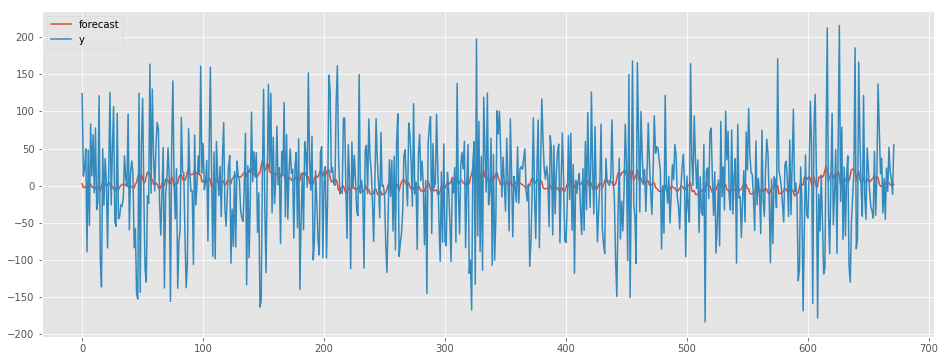

In [7]:
armodel = best_arima['model']

fig2 = plt.figure(figsize=(16,6))
axx = fig2.add_subplot(111)
armodel.plot_predict(ax = axx);

### Analysis of Residuals for best selected ARIMA model
+ We check if the residuals are normal. For this we use the Jarque-Bera test for normality. 

In [8]:
arresid = armodel.resid 
jbres = sm.stats.jarque_bera(arresid)

print("Jarque-Bera Normality Test on AR Residuals")
print("statistic: {}".format(jbres[0]))
print("p-value: {}".format(jbres[1]))
print('skew: {}'.format(jbres[2]))
print('kurtosis: {}'.format(jbres[3]))

Jarque-Bera Normality Test on AR Residuals
statistic: 1.5098564497740838
p-value: 0.4700443510061998
skew: -0.10713348436248081
kurtosis: 3.0895159804068806


+ The residuals are skewed to the left and are leptokurtic (fat tails). 
+ The qq-plot shows this large deviation from normality.

[Text(0.5, 1.0, 'QQ Plot of Residuals')]

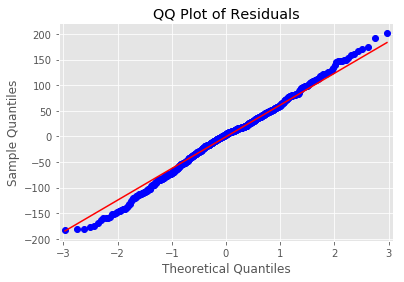

In [9]:
axxx = plt.figure().add_subplot(111)
sm.graphics.qqplot(arresid, line='q', ax = axxx)
axxx.set(title = 'QQ Plot of Residuals')

+ It shows that daily returns are non-normal and simple AR model is not a good fit for our data.

### White noise ARMA Model Fitting
+ Using our utility function to find the white noise ARMA model.

In [11]:
wn_arma, wn_arma_results = auto_arima(sp_df.DailyRet.values, p_max = 0, q_max = 0, d_max=0, verbose=True)

ARIMA(0, 0, 0) AIC:7578.85  BIC:7587.87
Best model params:(0, 0, 0) AIC:7578.85  BIC:7587.87


In [12]:
wn_arma['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:                     ARMA(0, 0)   Log Likelihood               -3787.423
Method:                           css   S.D. of innovations             67.837
Date:                Tue, 09 Apr 2019   AIC                           7578.846
Time:                        11:13:01   BIC                           7587.866
Sample:                             0   HQIC                          7582.339
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7275      2.617      1.042      0.298      -2.401       7.856
==============================================================================
"""

### Analysis of Residuals for white noise ARMA model

In [13]:
armodel_wn = wn_arma['model']
arresid_wn = armodel_wn.resid 
jbres_wn = sm.stats.jarque_bera(arresid_wn)

print("Jarque-Bera Normality Test on AR Residuals")
print("statistic: {}".format(jbres_wn[0]))
print("p-value: {}".format(jbres_wn[1]))
print('skew: {}'.format(jbres_wn[2]))
print('kurtosis: {}'.format(jbres_wn[3]))

Jarque-Bera Normality Test on AR Residuals
statistic: 0.6653429629453448
p-value: 0.717005705127056
skew: 0.02162822835081098
kurtosis: 3.1479565058733145


[Text(0.5, 1.0, 'QQ Plot of Residuals')]

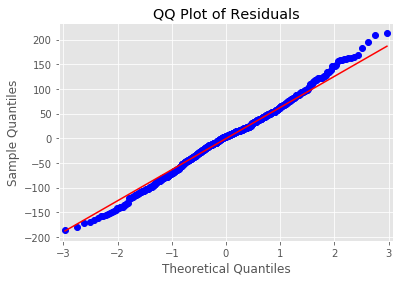

In [14]:
axxx = plt.figure().add_subplot(111)
sm.graphics.qqplot(arresid_wn, line='q', ax = axxx)
axxx.set(title = 'QQ Plot of Residuals')